In [37]:
import os, yaml, sys
import numpy as np
import matplotlib.pyplot as plt

ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from general_utils.utils import get_lagplot, compute_dRSA, delete_empty_keys
from general_utils.regression import lagged_linear_regression
from neural_utils.utils import load_monkey_data, load_stimuli_models, random_trials_per_rep, min_max_normalization, extract_fixation_responses_sing_trial, extract_fixation_responses_sing_stim, extract_all_fixation_responses

In [39]:
monkey_name = "red"
month = 'aug'
day = 25
resolution_Hz = 100
npx = False
imec_n = 0
normalization = None
model_name = "alexnet_features.0"
day = str(day)
neural_data, gaze_data = load_monkey_data(paths, monkey_name, day, month, resolution_Hz, npx=npx, imec_n=imec_n)
# normalizes them 
if normalization == "min_max":
    n_norm = min_max_normalization(neural_data)
# ADD zscore? robust?
elif normalization == None:
    n_norm = delete_empty_keys(neural_data)

# loads and upsamples the model 
all_models = load_stimuli_models(paths, model_name, n_norm.keys(), resolution_Hz)

# extract_fixation_responses(n_norm, gaze_data, all_models, n_timepts_bef, n_timepts_aft, foreperiod_len_timepts=30)

In [40]:
neural_data_fix, gaze_data_fix, model_data_fix = extract_all_fixation_responses(neural_data, gaze_data, all_models, 10, 40, stack=1)
#(n_norm, gaze_data, all_models, n_timepts_bef, n_timepts_aft, foreperiod_len_timepts=30, stack=0)

In [41]:
neural_data_fix.shape

(64, 50, 1999)

In [42]:
# from neural_utils.utils import face_fixations
# tot_face_fixation, tot_occluded_face_fixation, tot_non_face_fixation, tot_rep_face_fixation = face_fixations(paths, monkey_name, range(19, 25), month, npx, imec_n, resolution_Hz, 5, 20, 30, "human_face_detection", normalization)
# tot_face_fixation.shape

In [43]:
mod = model_data_fix #neural_data_fix[0:20, :,:]
neu = neural_data_fix[:, :,:]
lr_list = lagged_linear_regression(mod, neu, regression_type='ridge', cv_type='kf', n_splits=5, alpha=0.1, max_lag=10)
#lp = get_lagplot(compute_dRSA(neu[:,:,:100], mod[:,:,:100], metric_RDM = "euclidean"), max_lag=10)

/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/tizianocausin

8

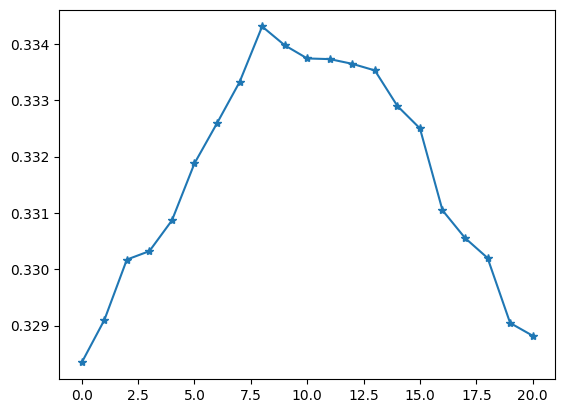

In [35]:
plt.plot(lr_list, marker="*")
#plt.plot(np.sqrt(np.abs(lp)) +0.6, marker="o")
np.argmax(lr_list)